# VisPlot
#### Calculates target visibility over requested nights and plots in graph format
#### Requries two files, one of locations, and one of targets, see example files supplied for formats, 'locations' and 'testfile'
#### Set target filename and output filename below

In [1]:
input_file = 'testfile'
output_file = 'testjson'

In [2]:
import numpy as np
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
import datetime as dt
from astropy.coordinates import SkyCoord
import json

#### Create target object

In [3]:
#makes a target object
class Visibility:
    def __init__(self, target_name, obs_date, coordinates, obs_name, latitude, longitude, altitude):
        """Creates an observation target from the specified parameters
        :param target_name: target identifier
        :param obs_date: date of observation
        :param coordinates: RA and Dec in SkyCoord object
        :param obs_name: observatory name
        :param latitude: observatory latitude
        :param longitude: observation longitude
        :param altitude: observatory altitude
        """
        self.date = obs_date
        self.name = target_name
        self.coord = coordinates
        self.loc = obs_name
        self.lati = float(latitude)
        self.long = float(longitude)
        self.alti = float(altitude)

#### Create location object

In [4]:
#makes a location object
class Location:
    def __init__(self, obs_name, latitude, longitude, altitude):
        """Creates a location object from specified parameters
        :param obs_name: observatory name
        :param latitude: observatory latitude
        :param longitude: observation longitude
        :param altitude: observatory altitude
        """
        self.loc = obs_name
        self.lati = latitude
        self.long = longitude
        self.alti = altitude

#### Load in location list from location file

In [5]:
locations=[] #list of observatories
keys=[] #observatory keys
locfilename = 'locations' #location file
file = open(locfilename,'r')

#read file one line at a time, extract data from each
for line in file:
    if line[0] != '!': #check for comments
        tokens = []
        split = line.split()
        
        #extract information from line
        for token in split:
            tokens.append(token) 
        loc = tokens[0]
        lat = tokens[1]
        lon = tokens[2]
        alt = tokens[3]
        
        if tokens[0] not in keys: #check if location is already in list, only add if new
            keys.append(tokens[0]) 
            newloc = Location(loc, lat, lon, alt) #initialise location object
            locations.append(newloc) #add to list

#### Load in list of targets from file, using location list if location is specified

In [6]:
file = open(input_file,'r') #open file

targets=[]

#read file one line at a time, extract data from each
for line in file:
    if line[0] != '!':
        tokens = []
        split = line.split()
        
        #extract information from line
        for token in split:
            tokens.append(token)
        target = tokens[0]
        date = tokens[1]
        ra = tokens[2]
        dec = tokens[3]
        coord = SkyCoord(ra, dec) #convert RA and Dec to SkyCoord
        
        loc = tokens[4] #obtain location
        
        if loc in keys: #check list for location
            index = keys.index(loc) #obtain location index
            #set location data
            lat = locations[index].lati
            lon = locations[index].long
            alt = locations[index].alti
            
        else: #if location not known, use rest of input for location data
            lat = tokens[5]
            lon = tokens[6]
            alt = tokens[7]

        newtarget = Visibility(target, date, coord, loc, lat, lon, alt) #create target object
        targets.append(newtarget) #add to list

### For each target:
#### Determine time range, find coordinates of target and moon over time range in altaz format
#### Determine day, twilight, and night ranges, max target altitude, and average moon phase
#### Plot everything on one graph per target, saves each with filename "date-target-location"
#### Compile outputs into dictionary and write into json file

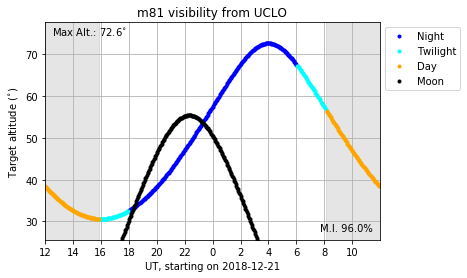

{"date": "2018-12-21", "target": "m81", "observatory": "UCLO", "night start": "15:54", "night end": "8:06", "observability": true, "altitude start": 30.61941, "altitude middle": 57.47402, "altitude end": 56.81627}


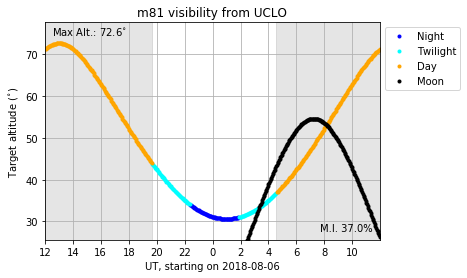

{"date": "2018-08-06", "target": "m81", "observatory": "UCLO", "night start": "19:42", "night end": "4:33", "observability": true, "altitude start": 43.7874, "altitude middle": 31.12627, "altitude end": 36.8182}


In [7]:
datewidth = 1.0/24/20 #set number of data points

output = open(output_file,'w')

#loop over all targets
for i in range(0,len(targets)):
    #determine time range
    ymd = [int(j) for j in targets[i].date.split('-')] #extract date data for each target
    date = dt.datetime(*ymd) # convert to DateTime object
    jd = pyasl.jdcnv(date) #find Julian date
    jd_start = jd-0.5 #start of time range
    jd_end = jd+0.5 #end of time range
    jds = np.arange(jd_start,jd_end, datewidth) #array of points across time range
    jdsub = jds-np.floor(jds[0])
    
    #find altaz coordinates for target over time range
    altaz = pyasl.eq2hor(jds, np.ones(jds.size)*targets[i].coord.ra.deg, np.ones(jds.size)*targets[i].coord.dec.deg, lat=targets[i].lati, lon=targets[i].long, alt=targets[i].alti)
    
    #find sun position over the time range
    sunpos = pyasl.sunpos(jd)
    sun_ra, sun_dec = sunpos[1], sunpos[2]
    sunpos_altaz = pyasl.eq2hor(jds, np.ones(jds.size)*sun_ra, np.ones(jds.size)*sun_dec, lat=targets[i].lati, lon=targets[i].long, alt=targets[i].lati)
    
    #find moon position over the time range
    mpos = pyasl.moonpos(jds)
    m_ra, m_dec = mpos[0], mpos[1]
    mpos_altaz = pyasl.eq2hor(jds, np.ones(jds.size)*m_ra, np.ones(jds.size)*m_dec, lat=targets[i].lati, lon=targets[i].long, alt=targets[i].alti)

    mpha = pyasl.moonphase(jds) #find moonphase
    avg_mpha = np.mean(mpha)
    moonvis = np.where(mpos_altaz[0] > 0.0)[0] #find whether moon is visible
    
    #find ranges on day, twilight, and night
    day = np.where(sunpos_altaz[0] >= 0.0)[0]
    twi = np.where(np.logical_and(sunpos_altaz[0] > -18.0, sunpos_altaz[0] <0.0))[0]
    night = np.where(sunpos_altaz[0] <= -18.0)[0]
    
    #plot visbility curve of target and moon
    plt.plot(jdsub[night],altaz[0][night],'.',label='Night',color='blue')
    plt.plot(jdsub[twi],altaz[0][twi],'.',label='Twilight',color='cyan')
    plt.plot(jdsub[day],altaz[0][day],'.',label='Day',color='orange')
    plt.plot(jdsub, mpos_altaz[0],'.',label='Moon',color='black')
    
    maxalt = max(altaz[0]) #find max target altitude
    
    axes = plt.gca()
    
    #set x labels to UTC time
    xrange = axes.get_xlim()
    jdhours = np.arange(0,3,1.0/12.0)
    utchours = (np.arange(0,72,2,dtype=int)+12)%24
    plt.xticks(jdhours,utchours)
    
    #graph settings
    plt.xlabel('UT, starting on '+targets[i].date)
    plt.ylabel('Target altitude ($^{\circ}$)')
    plt.grid()
    lgd = plt.legend(bbox_to_anchor=(1,1))
    plt.title(targets[i].name+' visibility from '+targets[i].loc)
    plt.xlim(jdsub[0],jdsub[len(jdsub)-1])
    plt.ylim(min(altaz[0])-5,max(altaz[0])+5)
    plt.text(0.82,min(altaz[0]-3),'M.I. '+str(np.round(avg_mpha,2)*100)+'%') #calculate average moon illumination
    plt.axvspan(0,jdsub[twi][0], color='k', alpha=0.1)
    plt.axvspan(jdsub[twi][len(jdsub[twi])-1], 1, color='k',alpha=0.1)
    plt.text(0.02,maxalt+2,'Max Alt.: '+str(np.round(maxalt,1))+'$^{\circ}$')
    
    #plot graph
    plt.savefig(targets[i].date+'-'+targets[i].name+'-'+targets[i].loc,dpi=300, bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.show()
    
    #dictionary
    observable = False
    
    #extract night start time
    night_start = jdsub[twi][0]
    ns_hour = str(int(str(night_start*24)[0])+12) #convert from JD to decimal, take first digit as hour
    ns_min_raw = str(int(np.round(night_start*24%1*60,2))) #convert from JD to decimal, take decimal, convert to minutes
    #check for two digit minutes
    if len(ns_min_raw) == 1:
        ns_min = str('0'+ns_min_raw)
    else:
        ns_min = ns_min_raw
    ns_utc = ns_hour+":"+ns_min
    
    #extract night end time
    night_end = jdsub[twi][len(jdsub[twi])-1]
    ne_hour = str((night_end-0.5)*24)[0] #convert from JD to decimal, take first digit as hour
    ne_min_raw = str(int(np.round(night_end*24%1*60,2))) #convert from JD to decimal, take decimal, convert to minutes
    #check for two digit minutes
    if len(ne_min_raw) == 1:
        ne_min = str('0'+ne_min_raw)
    else:
        ne_min = ne_min_raw
    ne_utc = ne_hour+":"+ne_min

    
    alt_start = altaz[0][twi][0] #altitude at start of night
    alt_end = altaz[0][twi][len(jdsub[twi])-1] #altitude at end of night
    #altitude around midnight
    index = len(jdsub)/2
    index_test = index%1
    if index_test != 0:
        midindex = int(index+0.5)
    else:
        midindex = int(index)
    alt_mid = altaz[0][midindex]

    #check if target moves above horizon
    if max(altaz[0] > 0):
        observable = True
        
    #round floats    
    alt_start = np.round(alt_start,5)
    alt_mid = np.round(alt_mid,5)
    alt_end = np.round(alt_end,5)
        
    #put data into dictionary
    out_data = {
        'date' : targets[i].date,
        'target' : targets[i].name,
        'observatory' : targets[i].loc,
        'night start' : ns_utc,
        'night end' : ne_utc,
        'observability' : observable,
        'altitude start' : alt_start,
        'altitude middle' : alt_mid,
        'altitude end' : alt_end
        
    }
    
    json_data = json.dumps(out_data, ensure_ascii=False) #convert dictionary to json
    print(json_data)
    output.write(json_data+'\n') #write to file


output.close()